<a href="https://colab.research.google.com/github/xiangyu066/DL-FlaNet/blob/master/FlaNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!/opt/bin/nvidia-smi

Mon Nov 11 14:41:14 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    37W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# **Acess to Google drive**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import keras
from keras import models, layers, regularizers, optimizers
from keras.layers import Dropout, LeakyReLU
from keras.callbacks import LearningRateScheduler
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


# **Importing datasets**

In [4]:
cd /content/gdrive/My Drive/Colab Notebooks/FlaNet/trainingDatasets/trainingImages_npy/

/content/gdrive/My Drive/Colab Notebooks/FlaNet/trainingDatasets/trainingImages_npy


In [0]:
trainingImages = []
trainingLabels = []

trainingImages_Flagellated = np.load('Flagellated_images.npy')
trainingImages = trainingImages_Flagellated
trainingLabels_Flagellated = np.load('Flagellated_labels_hot.npy')
trainingLabels = trainingLabels_Flagellated

trainingImages_nonFlagellated = np.load('nonFlagellated_images.npy')
trainingImages = np.append(trainingImages,trainingImages_nonFlagellated,axis=0)
trainLabels_nonFlagellated = np.load('nonFlagellated_labels_hot.npy')
trainingLabels = np.append(trainingLabels,trainLabels_nonFlagellated,axis=0)

# z-zero normalization
trainingImages = trainingImages.astype('float32')
mean_train = np.mean(trainingImages,axis=(0,1,2,3))
std_train = np.std(trainingImages,axis=(0,1,2,3))
trainingImages = (trainingImages-mean_train)/(std_train+1e-7)

# manual shuffle
idx = np.random.permutation(len(trainingLabels))
trainingLabels=trainingLabels[idx]
trainingImages=trainingImages[idx,]

In [6]:
cd /content/gdrive/My Drive/Colab Notebooks/FlaNet/trainingDatasets/testImages_npy/

/content/gdrive/My Drive/Colab Notebooks/FlaNet/trainingDatasets/testImages_npy


In [0]:
testImages = []
testLabels = []

testImages_Flagellated = np.load('Flagellated_images.npy')
testImages = testImages_Flagellated
testLabels_Flagellated = np.load('Flagellated_labels_hot.npy')
testLabels = testLabels_Flagellated

testImages_nonFlagellated = np.load('nonFlagellated_images.npy')
testImages = np.append(testImages,testImages_nonFlagellated,axis=0)
testLabels_nonFlagellated = np.load('nonFlagellated_labels_hot.npy')
testLabels = np.append(testLabels,testLabels_nonFlagellated,axis=0)

# z-zero normalization
testImages = testImages.astype('float32')
mean_test = np.mean(testImages,axis=(0,1,2,3))
std_test = np.std(testImages,axis=(0,1,2,3))
testImages = (testImages-mean_test)/(std_test+1e-7)

In [8]:
print('The size of trainingImages:', trainingImages.shape)
print('The size of testImages:', testImages.shape)
print(trainingImages.shape[0], 'train samples')
print(testImages.shape[0], 'test samples')

The size of trainingImages: (19072, 128, 128, 1)
The size of testImages: (4768, 128, 128, 1)
19072 train samples
4768 test samples


# **Training a neural network**

In [9]:
FlaNet = models.Sequential()
FlaNet.add(layers.Conv2D(32, (5, 5), input_shape=(128, 128, 1), padding='same'))
FlaNet.add(LeakyReLU(alpha=0.1))
FlaNet.add(layers.Conv2D(32, (5, 5), padding='same'))
FlaNet.add(LeakyReLU(alpha=0.1))
FlaNet.add(layers.MaxPooling2D((2, 2)))

FlaNet.add(layers.Conv2D(64, (5, 5), padding='same'))
FlaNet.add(LeakyReLU(alpha=0.1))
FlaNet.add(layers.Conv2D(64, (5, 5), padding='same'))
FlaNet.add(LeakyReLU(alpha=0.1))
FlaNet.add(layers.MaxPooling2D((2, 2)))
FlaNet.add(Dropout(0.3))

FlaNet.add(layers.Conv2D(128, (5, 5), padding='same'))
FlaNet.add(LeakyReLU(alpha=0.1))
FlaNet.add(layers.Conv2D(128, (5, 5), padding='same'))
FlaNet.add(LeakyReLU(alpha=0.1))
FlaNet.add(layers.MaxPooling2D((2, 2)))
FlaNet.add(Dropout(0.4))

FlaNet.add(layers.Flatten())
FlaNet.add(layers.Dense(128, activation='relu'))
FlaNet.add(Dropout(0.5))
FlaNet.add(layers.Dense(1, activation='sigmoid')) 

FlaNet.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        51264     


In [10]:
# define a learning schedual
def step_decay(epoch):
    initial_lrate = 1e-4
    drop = 0.5
    epochs_drop = 5
    lrate = initial_lrate*math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate

FlaNet.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
history = FlaNet.fit(trainingImages, trainingLabels, 
                     epochs=20, batch_size=64, 
                     validation_data=(testImages,testLabels), 
                     shuffle=True, 
                     callbacks=[LearningRateScheduler(step_decay)])




Train on 19072 samples, validate on 4768 samples
Epoch 1/20





19072/19072 [==============================] - 30s 2ms/step - loss: 0.3831 - acc: 0.8220 - val_loss: 0.1443 - val_acc: 0.9520
Epoch 2/20
19072/19072 [==============================] - 26s 1ms/step - loss: 0.1350 - acc: 0.9548 - val_loss: 0.0479 - val_acc: 0.9862
Epoch 3/20
19072/19072 [==============================] - 26s 1ms/step - loss: 0.0725 - acc: 0.9796 - val_loss: 0.1134 - val_acc: 0.9597
Epoch 4/20
19072/19072 [==============================] - 26s 1ms/step - loss: 0.0576 - acc: 0.9841 - val_loss: 0.0280 - val_acc: 0.9920
Epoch 5/20
19072/19072 [==============================] - 26s 1ms/step - loss: 0.0402 - acc: 0.9893 - val_loss: 0.0277 - val_acc: 0.9910
Epoch 6/20
19072/19072 [==============================] - 26s 1ms/step - loss: 0.0339 - acc: 0.9904 - val_loss: 0.0268 - val_acc: 0.9912
Epoch 7/20
19072/19072 [==============================] - 26s 1ms/step - loss: 0.0308 - acc: 0.9921 - val_loss: 0.0224 - 

In [12]:
test_loss, test_acc = FlaNet.evaluate(testImages, testLabels)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

4768/4768 [==============================] - 2s 487us/step
Test loss: 0.02656648431708894
Test accuracy: 0.993498322147651


# **Confusion matrix**

In [0]:
test_predict = FlaNet.predict(testImages)
##
# binary crossentropy
predictLabels = [1 * (test_predict[i]>=0.5) for i in range(len(test_predict))]
predictLabels = np.array(predictLabels)

# categorical crossentropy
#predictLabels = np.array([np.argmax(test_predict[i]) for i in range(len(test_predict))])
#testLabels = np.array([np.argmax(testLabels[i]) for i in range(len(test_predict))])

In [14]:
predictLabels.shape

(4768, 1)

In [15]:
testLabels.shape

(4768,)

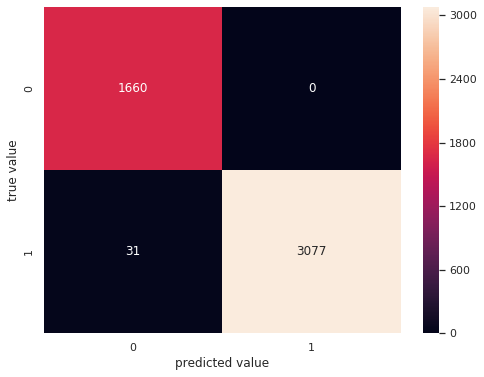

In [16]:
mat = confusion_matrix(predictLabels, testLabels)

plt.figure(figsize=(8,6))
ax=sns.heatmap(mat, square=False, annot=True, fmt="d", cbar=True)

# !!! There is a bug in matplotlib ver.3.1.1 causing truncated heatmap 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
# !!!

plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

# **Inspection of overfitting**

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

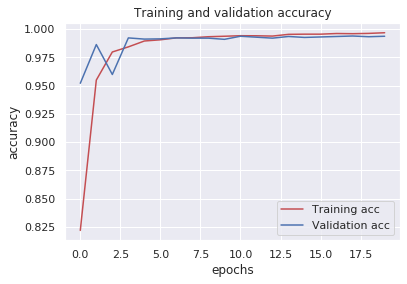

In [18]:
plt.figure()
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

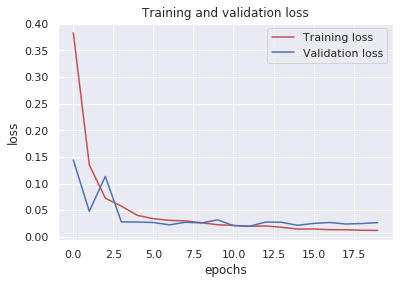

In [19]:
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

#**Save trained network & history**

In [20]:
cd /content/gdrive/My Drive/Colab Notebooks/FlaNet/trainingDatasets/

/content/gdrive/My Drive/Colab Notebooks/FlaNet/trainingDatasets


In [0]:
# save trained network
FlaNet.save('FlaNet.h5') 

In [0]:
# save history
import pandas as pd
   
FlaNet_df = pd.DataFrame(history.history) 

with open('FlaNet.csv', mode='w') as f:
    FlaNet_df.to_csv(f)